### Imports

In [159]:
import pysimdamicm as ccd

import ROOT

import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt

In [160]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from skimage.measure import label, regionprops

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [161]:
plt.rcParams["text.usetex"] = False

### Calibration

In [180]:
# Start with 1 raw image CCD (just took the first image 5)
path = "raw_img_data/avg_Image_8_Low_Temp_109_20251117_102727_2.fz"
json_file = "pysimdamicm/pysimdamicm/json/moduletest_lowtemp_image_8.json"

In [181]:
from pysimdamicm.scripts.calibrate import calibrate

In [182]:
calibrated_img = calibrate(path, json_file, save=False, return_array=True)

[1/8] Loading configuration...
[2/8] Building RawData object...
Exposure time: 0.0s
Total Read-out time: 58348.409352s
Total time (exp+readout): 58348.409352s
WARNING ERROR: Parameter ampdir will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter itgtime will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter ampl will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter read_time will be ignored, not found in the data image header (extension 1)
<panaSKImg> info: Fits file does not contain an skip image, Nskips sets to 1 (from header 1000).
[3/8] Preparing data...
RawData INFO.
 *********************************************************************** 
 * Define mask for sensor and over/pre-scan regions 'avg_Image_8_Low_Temp_109_20251117_102727_2.fz'
 *********************************************************************** 
  INFO: Rows and column region for the overscan, prescan and Act

In [183]:
ccds = np.vsplit(calibrated_img, 4)

In [184]:
ccd1, ccd2, ccd3, ccd4 = ccds

In [185]:
ccd1.shape

(500, 3500)

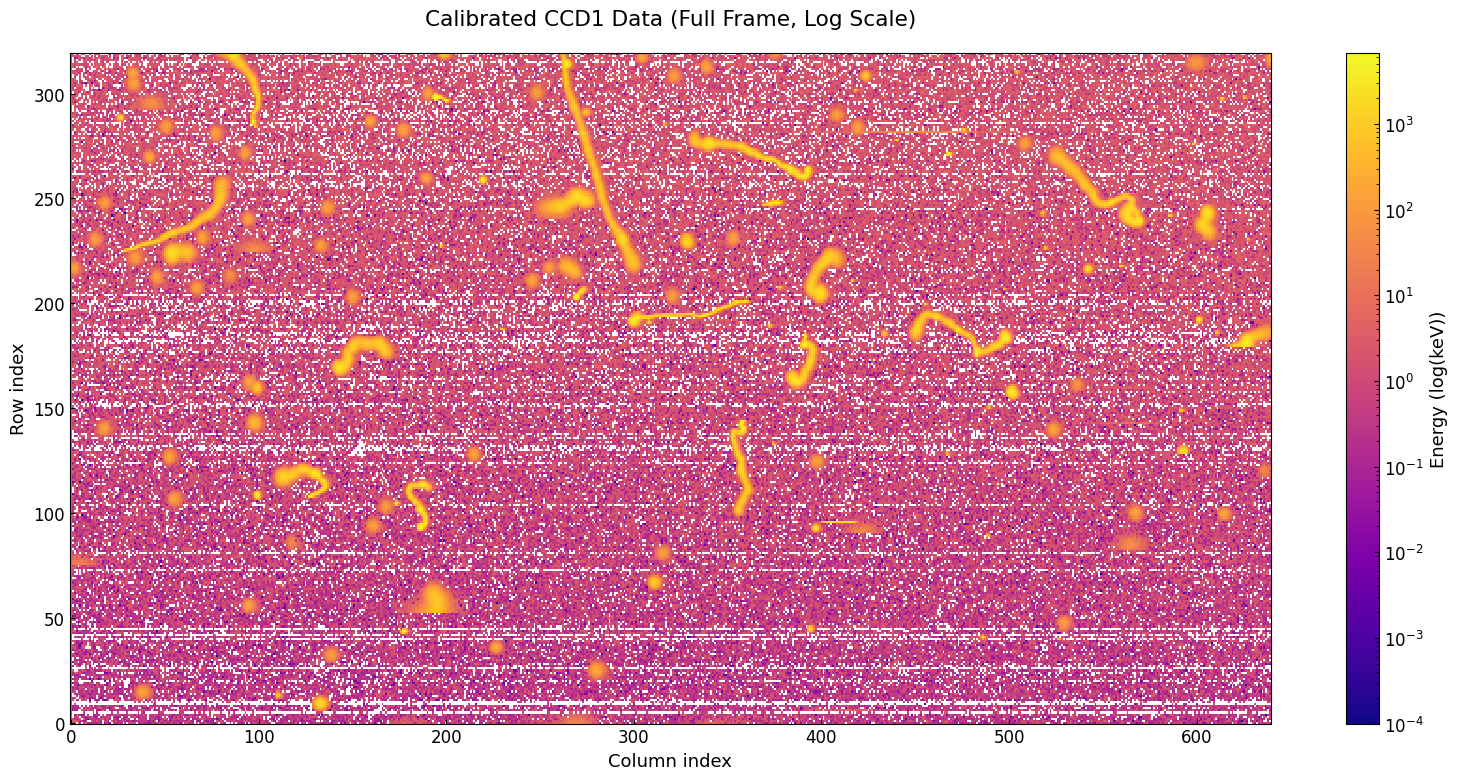

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

ccd = ccd1   # full CCD1

plt.figure(figsize=(16, 8))
cmap = plt.cm.plasma

# safe LogNorm in case of zeros
norm = colors.LogNorm(
    vmin=max(ccd.min(), 1e-4),
    vmax=ccd.max()
)

img = plt.imshow(
    ccd,
    cmap=cmap,
    origin='lower',
    aspect='auto',
    norm=norm,
    interpolation='none'
)

plt.colorbar(img, label='Energy (log(keV))')
plt.title("Calibrated CCD1 Data (Full Frame, Log Scale)")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.tight_layout()
plt.show()



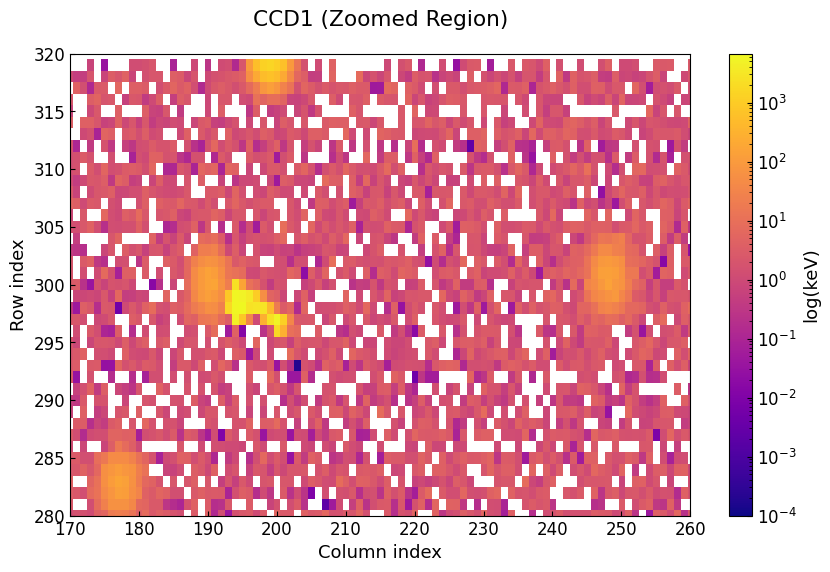

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

# your CCD1
ccd = ccd1

# region of interest
x_min, x_max = 170, 260
y_min, y_max = 280, 320

plt.figure(figsize=(10, 6))
cmap = plt.cm.plasma

# log norm, but safe for zeros
norm = colors.LogNorm(
    vmin=max(ccd.min(), 1e-4),
    vmax=ccd.max()
)

img = plt.imshow(
    ccd,
    cmap=cmap,
    origin='lower',
    aspect='auto',
    norm=norm,
    interpolation='none'
)

plt.colorbar(img, label='log(keV)')
plt.title("CCD1 (Zoomed Region)")
plt.xlabel("Column index")
plt.ylabel("Row index")

# zoom to your defined chunk
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [ ]:
cut_ccd1 = ccd1[y_min:y_max, x_min:x_max]


### Helpers

In [ ]:
# helper to make threshold cut to image to remove noise
def apply_percentile_threshold(cal_img, percentile=95, fill_value=np.nan):
    """
    Apply a global percentile cut on the RAW calibrated image (E in e-).
    Pixels <= threshold are set to `fill_value` (np.nan by default).

    Returns:
      masked_img : 2D array with only >thr pixels kept
      thr        : numeric threshold used
      keep       : boolean mask (True for kept pixels)
    """
    thr = np.percentile(cal_img, percentile)  # compute on RAW E
    keep = cal_img > thr                      # strict '>' to drop exactly bottom p%
    masked_img = np.where(keep, cal_img, fill_value)
    return masked_img, thr, keep

In [ ]:
def make_samples_from_masked(masked_img):
    """
    Build N x 3 samples from an already-thresholded image.
    Accepts either NaN-filled backgrounds or zeros; only finite, >0 values are used.
    Returns:
      X_raw : (N,3) with columns [y, x, log1p(E)]
      idx_yx: (N,2) integer pixel coords [y, x]
    """
    # valid pixels are finite and > 0
    valid = np.isfinite(masked_img) & (masked_img > 0)
    ys, xs = np.nonzero(valid)
    E = masked_img[ys, xs].astype(np.float64)

    # 3-D features for GMM
    X_raw = np.column_stack([ys, xs, np.log1p(E)])
    idx_yx = np.column_stack([ys, xs])
    return X_raw, idx_yx

In [ ]:
REG_COVAR = 1e-6
RANDOM_STATE = 209

def _unscale_covariances(gmm, scaler):
    """
    Map covariances from standardized space back to original feature space.
    Handles only covariance_type='full' (what you're using).
    """
    if gmm.covariance_type != "full":
        raise ValueError("This helper currently assumes covariance_type='full'.")

    D = np.diag(scaler.scale_)
    covs_std = gmm.covariances_                 # shape: (K, d, d)
    covs_raw = np.empty_like(covs_std)
    for k in range(covs_std.shape[0]):
        covs_raw[k] = D @ covs_std[k] @ D       # Σ_raw = D Σ_std D
    return covs_raw

def fit_gmms_over_K(X_raw, K_RANGE, reg_covar=REG_COVAR, random_state=RANDOM_STATE):
    """
    Standardize features, fit a full-covariance GMM for each K.
    Returns: list of dicts with model, labels, BIC, AIC, scaler, and
             means/covariances mapped back to ORIGINAL units.
    """
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_raw)

    results = []
    for K in K_RANGE:
        gmm = GaussianMixture(
            n_components=K,
            covariance_type="full",
            reg_covar=reg_covar,
            random_state=random_state
        )
        gmm.fit(X_std)

        # Predict labels in standardized space, but keep for reference
        labels = gmm.predict(X_std)

        # --- NEW: parameters in original (unscaled) space ---
        means_raw = scaler.inverse_transform(gmm.means_)       # shape: (K, d)
        covs_raw  = _unscale_covariances(gmm, scaler)          # shape: (K, d, d)

        bic = gmm.bic(X_std)
        aic = gmm.aic(X_std)
        results.append({
            "K": K,
            "model": gmm,
            "labels": labels,         # labels on the standardized X
            "bic": bic,
            "aic": aic,
            "scaler": scaler,
            "means_raw": means_raw,   # <-- in original units
            "covs_raw": covs_raw      # <-- in original units
        })

    results.sort(key=lambda r: r["bic"])
    return results


In [ ]:
def plot_fullframe_clusters(idx_yx, labels, frame_size=(320, 640), title=None):
    H, W = frame_size
    y, x = idx_yx[:, 0], idx_yx[:, 1]

    fig, ax = plt.subplots(figsize=(8, 4.5))
    sc = ax.scatter(x, y, c=labels, s=2, cmap='tab20', linewidths=0)
    ax.set_xlim(-1, W)
    ax.set_ylim(-1, H)          # 0 bottom, H top
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("Column index (x)")
    ax.set_ylabel("Row index (y)")
    ax.set_title(title if title else "GMM clusters (full frame)")
    plt.colorbar(sc, ax=ax, label="Cluster ID", fraction=0.025, pad=0.02)
    plt.tight_layout(); plt.show()

In [ ]:
from scipy import ndimage as ndi

# helpers to remove small specles that may be confusing the model (only removes single, isolated pixels)
def remove_small_components(masked_img, min_pixels=20, connectivity=2):
    """
    masked_img: 2D array with signal pixels (finite >0) and background NaN (or 0)
    min_pixels: drop any connected component smaller than this
    connectivity: 1 = 4-connected, 2 = 8-connected (recommended)

    Returns:
      cleaned_img : masked_img with small components set to NaN
      keep_mask   : boolean mask of retained components
      labeled     : labeled array of components (for debugging, 0 = background)
    """
    # binary mask of candidate signal pixels
    sig = np.isfinite(masked_img) & (masked_img > 0)

    # label connected components
    structure = ndi.generate_binary_structure(2, connectivity)   # 3x3 for 8-conn
    labeled, n = ndi.label(sig, structure=structure)

    # compute sizes and build keep mask
    counts = np.bincount(labeled.ravel())
    keep_ids = np.flatnonzero(counts >= min_pixels)              # include 0 automatically
    keep = np.isin(labeled, keep_ids)

    cleaned = np.where(keep, masked_img, np.nan)
    return cleaned, keep, labeled

In [ ]:
def _inverse_transform_mean_cov_full(scaler, mean_z, cov_z):
    """Back-transform mean/cov from z-scored space to original units."""
    mu = scaler.mean_
    sc = scaler.scale_
    D = np.diag(sc)
    mean_orig = mu + sc * mean_z
    cov_orig  = D @ cov_z @ D
    return mean_orig, cov_orig

In [ ]:
def gmm_xy_params(best_result):
    """
    From a fitted 3D GMM over [y,x,logE], return lists of:
      mus_xy[k] (2,), Sigmas_xy[k] (2x2), weights[k].
    """
    gmm = best_result["model"]
    sc  = best_result["scaler"]
    mus_xy, Sigmas_xy, weights = [], [], []
    for k in range(gmm.n_components):
        m3, C3 = _inverse_transform_mean_cov_full(sc, gmm.means_[k], gmm.covariances_[k])
        mus_xy.append(m3[:2])
        Sigmas_xy.append(C3[:2, :2])
        weights.append(gmm.weights_[k])
    return mus_xy, Sigmas_xy, np.array(weights)

In [ ]:
from matplotlib.colors import ListedColormap

def _make_palette(K, seed=0):
    rng = np.random.default_rng(seed)
    # Build a long categorical palette by combining tab20 variants + random shuffle
    base = []
    for name in ["tab20", "tab20b", "tab20c"]:
        base.extend(plt.colormaps[name](np.linspace(0, 1, 20))[:,:3])
    # If K > len(base), extend with HSV wheel
    if K > len(base):
        extra = plt.colormaps["hsv"](np.linspace(0, 1, K - len(base)))[:,:3]
        base = np.vstack([base, extra])
    colors = np.array(base)[:K]
    rng.shuffle(colors)
    return ListedColormap(colors)

In [ ]:
def plot_cluster_gallery(idx_yx, labels, frame_size, top_n=24, cols=6, sort_by="size", title=None):
    H, W = frame_size
    y, x = idx_yx[:,0], idx_yx[:,1]
    labels = np.asarray(labels)
    K = int(labels.max()) + 1

    sizes = np.bincount(labels, minlength=K)
    order = np.argsort(sizes)[::-1] if sort_by=="size" else np.arange(K)
    ids = order[:min(top_n, K)]

    rows = int(np.ceil(len(ids) / cols))
    cmap = _make_palette(len(ids))

    fig_w = 1.8*cols; fig_h = 1.8*rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes.ravel()

    for i, (ax, k) in enumerate(zip(axes, ids)):
        mk = labels == k
        ax.scatter(x[mk], y[mk], s=4, color=cmap(i), linewidths=0)
        ax.set_xlim(-1, W); ax.set_ylim(-1, H); ax.set_aspect('equal', 'box')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"ID {k}  (n={sizes[k]})", fontsize=9)
    # Hide any unused panels
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(title if title else f"Top {len(ids)} clusters (by size)", y=1.02, fontsize=12)
    plt.tight_layout(); plt.show()

### 3D GMM (with speck removal)

In [ ]:
# A) Apply the 95% cut 
masked_img, thr, keep = apply_percentile_threshold(ccd1, percentile=95, fill_value=np.nan)
print(f"[mask] threshold = {thr:.3f} keV ; kept pixels = {keep.sum()} / {keep.size}")

[mask] threshold = 6.470 keV ; kept pixels = 10240 / 204800


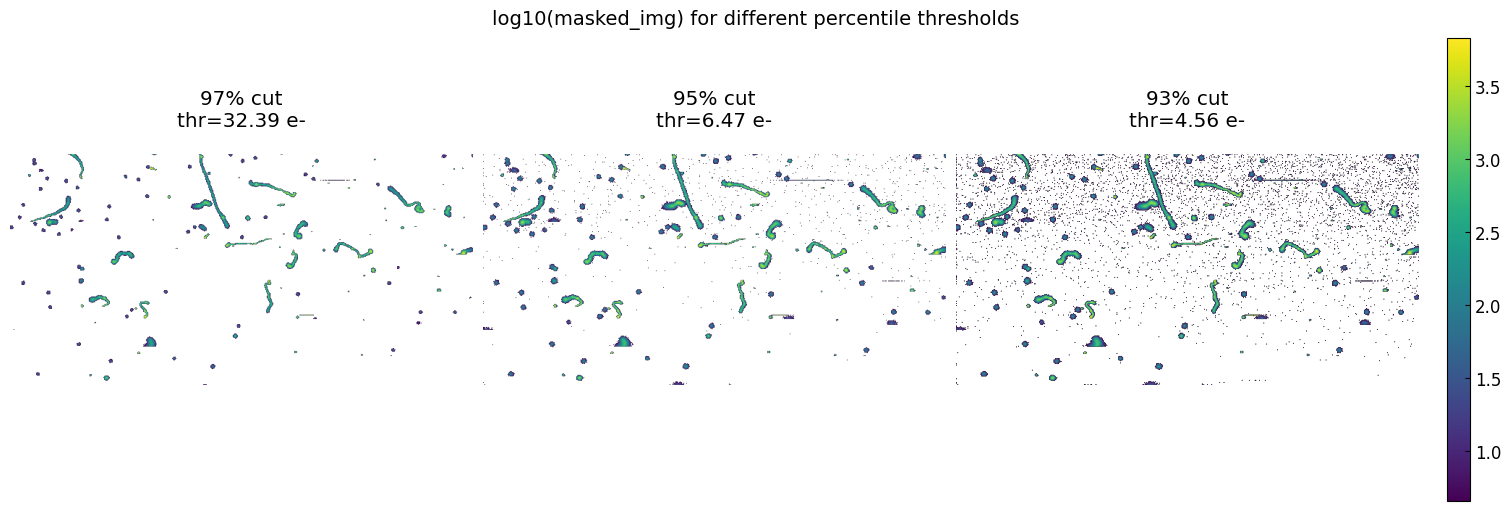

In [ ]:
percentiles = [97, 95, 93]
fig, axes = plt.subplots(1, len(percentiles), figsize=(15, 5), constrained_layout=True)

for ax, p in zip(axes, percentiles):
    masked_img, thr, keep = apply_percentile_threshold(ccd1, percentile=p, fill_value=np.nan)
    ax.imshow(np.log10(masked_img), origin='lower')
    ax.set_title(f"{p}% cut\nthr={thr:.2f} e-")
    ax.axis('off')

plt.suptitle("log10(masked_img) for different percentile thresholds", fontsize=14)
plt.colorbar(ax.imshow(np.log10(masked_img), origin='lower'),
             ax=axes, orientation='vertical', fraction=0.03, pad=0.02)
plt.show()


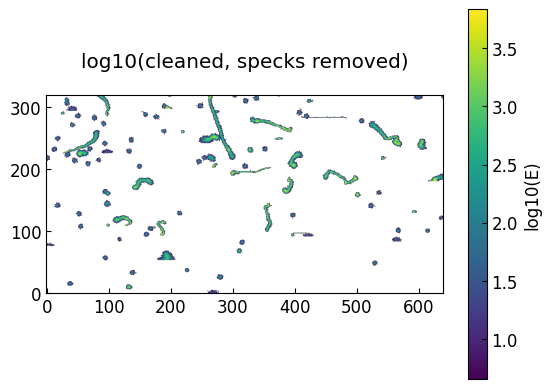

In [ ]:
# 2) remove specks (e.g., anything < 20 pixels, adjust!)
clean_img, keep_clean, labeled = remove_small_components(masked_img, min_pixels=20, connectivity=2)
plt.figure(); plt.imshow(np.log10(clean_img), origin='lower'); plt.title("log10(cleaned, specks removed)"); plt.colorbar(label="log10(E)"); plt.show()

In [ ]:
# assuming 'clean_img' is your speck-removed array
mask = np.isfinite(clean_img) & (clean_img > 0)
structure = ndi.generate_binary_structure(2, 2)   # 8-connected
labeled, n_clusters = ndi.label(mask, structure=structure)

print(f"Estimated number of connected clusters: {n_clusters}")

# K_range is +5, -5 around the n_clusters value found above
K_RANGE = list(range(max(1, n_clusters - 5), n_clusters + 6))
print(K_RANGE)

Estimated number of connected clusters: 90
[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


In [ ]:
# 3) build samples ONLY from retained components
X_raw_cleaned, idx_yx = make_samples_from_masked(clean_img)

In [ ]:
# 4) fit GMM as before
results_cleaned = fit_gmms_over_K(X_raw_cleaned, K_RANGE, reg_covar=REG_COVAR, random_state=RANDOM_STATE)

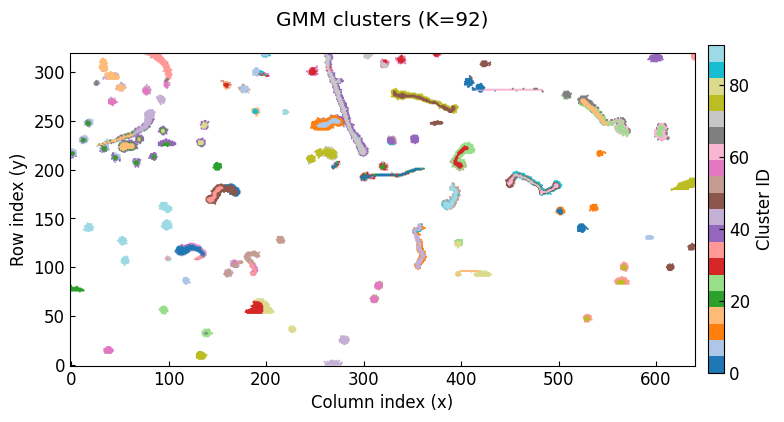

In [ ]:
best = results_cleaned[0]
plot_fullframe_clusters(idx_yx, best["labels"], frame_size=clean_img.shape, title=f"GMM clusters (K={best['K']})")

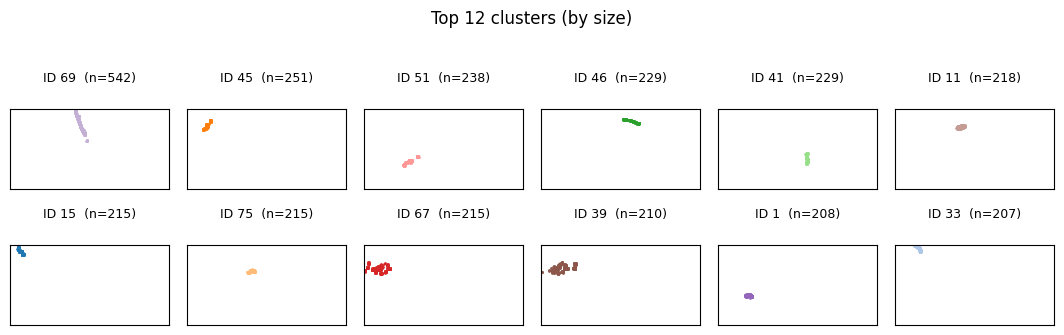

In [ ]:
plot_cluster_gallery(idx_yx, best["labels"], clean_img.shape, top_n=12, cols=6)

### GMM (without speck removal)

In [ ]:
masked_img, thr, keep = apply_percentile_threshold(ccd1, percentile=97, fill_value=np.nan)

In [ ]:
# assuming 'clean_img' is your speck-removed array
mask = np.isfinite(masked_img) & (masked_img > 0)
structure = ndi.generate_binary_structure(2, 2)   # 8-connected
labeled, n_clusters = ndi.label(mask, structure=structure)

print(f"Estimated number of connected clusters: {n_clusters}")

# K_range is +5, -5 around the n_clusters value found above
K_RANGE = list(range(max(1, n_clusters - 5), n_clusters + 6))
print(K_RANGE)

Estimated number of connected clusters: 139
[134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


In [ ]:
# 3) build samples ONLY from retained components
X_raw_thresh, idx_yx = make_samples_from_masked(masked_img)

In [ ]:
# K_range is +5, -5 around the n_clusters value found above
K_RANGE = list(range(max(1, n_clusters - 5), n_clusters + 6))
print(K_RANGE)

[134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


In [ ]:
results_thresh = fit_gmms_over_K(X_raw_thresh, K_RANGE, reg_covar=REG_COVAR, random_state=RANDOM_STATE)

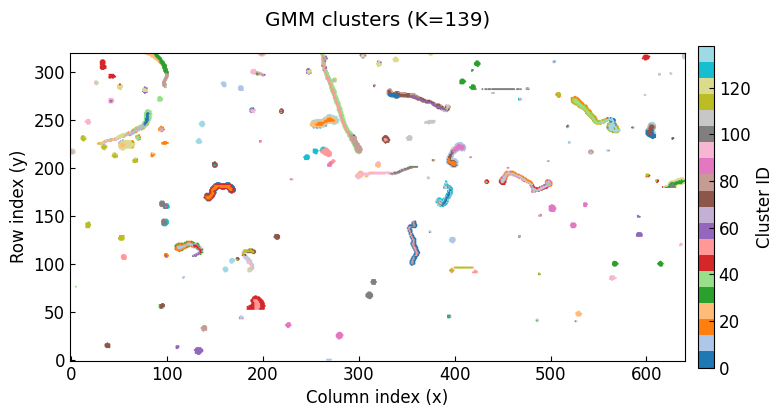

In [ ]:
best = results_thresh[0]
plot_fullframe_clusters(idx_yx, best["labels"], frame_size=masked_img.shape, title=f"GMM clusters (K={best['K']})")

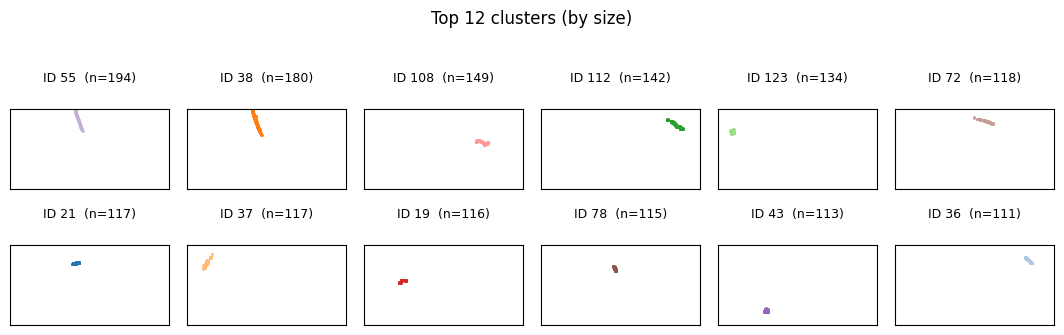

In [ ]:
plot_cluster_gallery(idx_yx, best["labels"], clean_img.shape, top_n=12, cols=6)

# cut ccd

In [309]:
x_min = 2090
x_max = 2210
y_min = 45
y_max = 125

In [310]:
cut_ccd1 = ccd1[y_min:y_max, x_min:x_max]

In [311]:
cut_ccd1.shape

(80, 120)

In [312]:
masked_img, thr, keep = apply_percentile_threshold(cut_ccd1, percentile=99.5, fill_value=np.nan)

In [313]:
clean_img, keep_clean, labeled = remove_small_components(masked_img, min_pixels=5, connectivity=2)

In [314]:
# assuming 'clean_img' is your speck-removed array
mask = np.isfinite(masked_img) & (masked_img > 0)
structure = ndi.generate_binary_structure(2, 2)   # 8-connected
labeled, n_clusters = ndi.label(mask, structure=structure)

print(f"Estimated number of connected clusters: {n_clusters}")

# K_range is +5, -5 around the n_clusters value found above
K_RANGE = list(range(max(1, n_clusters - 2), n_clusters + 2))
print(K_RANGE)

Estimated number of connected clusters: 7
[5, 6, 7, 8]


In [315]:
# 3) build samples ONLY from retained components
X_raw_cut, idx_yx = make_samples_from_masked(cut_ccd1)

In [316]:
results_cut = fit_gmms_over_K(X_raw_cut, K_RANGE, reg_covar=REG_COVAR, random_state=RANDOM_STATE)

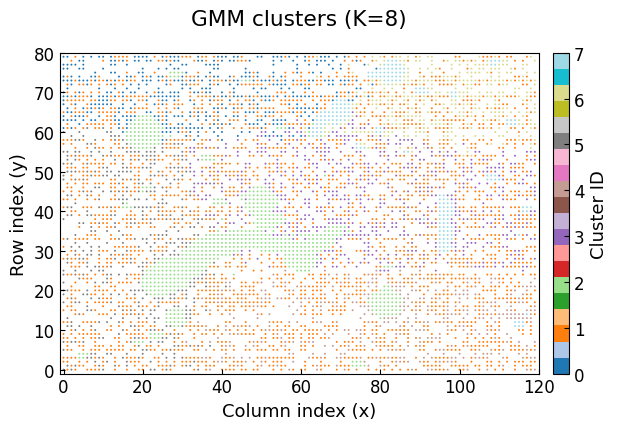

In [317]:
best = results_cut[0]
plot_fullframe_clusters(idx_yx, best["labels"], frame_size=cut_ccd1.shape, title=f"GMM clusters (K={best['K']})")

In [318]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_fullframe_clusters_2(idx_yx, labels, frame_size=(320, 640), title=None):
    H, W = frame_size
    y = idx_yx[:, 0]
    x = idx_yx[:, 1]

    # ---- Build an image where each pixel stores its cluster label ----
    img = np.full((H, W), -1, dtype=int)   # background = -1

    img[y, x] = labels

    # ---- Create color map: background white, clusters colored ----
    unique_labels = np.unique(labels)
    n_colors = unique_labels.max() + 1

    # tab20 but shifted to skip white
    base_cmap = plt.cm.tab20(np.linspace(0, 1, max(n_colors, 20)))
    # force bg = white
    colors = np.vstack([[1, 1, 1, 1], base_cmap[:n_colors]])

    cmap = ListedColormap(colors)

    # shift labels by +1 so that background (-1) becomes 0
    img_plot = img + 1

    # ---- Plot as filled square pixels ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.imshow(img_plot, origin='lower', cmap=cmap, interpolation='none')

    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("Column index (x)")
    ax.set_ylabel("Row index (y)")
    ax.set_title(title if title else "GMM clusters (full frame)")

    plt.tight_layout()
    plt.show()


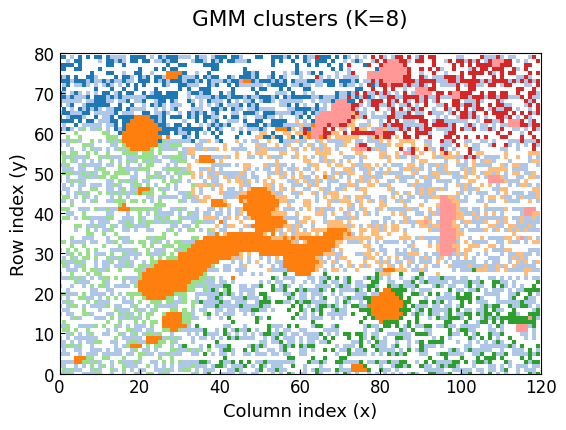

In [319]:
plot_fullframe_clusters_2(
    idx_yx,
    best["labels"],
    frame_size=cut_ccd1.shape,
    title=f"GMM clusters (K={best['K']})"
)


In [320]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_fullframe_clusters_3(idx_yx, labels, frame_size=(320, 640), title=None):
    H, W = frame_size
    y = idx_yx[:, 0]
    x = idx_yx[:, 1]

    # ---- Build an image where each pixel stores its cluster label ----
    img = np.full((H, W), -1, dtype=int)   # background = -1
    img[y, x] = labels

    # ---- Create color map: background white, clusters colored ----
    unique_labels = np.unique(labels)
    n_colors = unique_labels.max() + 1

    base_cmap = plt.cm.tab20(np.linspace(0, 1, max(n_colors, 20)))
    colors = np.vstack([[1, 1, 1, 1], base_cmap[:n_colors]])
    cmap = ListedColormap(colors)

    img_plot = img + 1  # background goes to 0

    # ---- Plot as filled square pixels ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.imshow(img_plot, origin='lower', cmap=cmap, interpolation='none')

    # -------------------------------------------------
    # OVERRIDE AXIS LABELS (NOT ZOOMING!)
    # -------------------------------------------------
    # Choose 5 ticks across the current image
    xticks = np.linspace(0, W, 5)
    yticks = np.linspace(0, H, 5)

    # Replace tick labels with desired CCD coordinates
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    ax.set_xticklabels(np.linspace(2000, 2200, 5, dtype=int))
    ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int))

    # -------------------------------------------------

    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title if title else "GMM clusters")

    plt.tight_layout()
    plt.show()


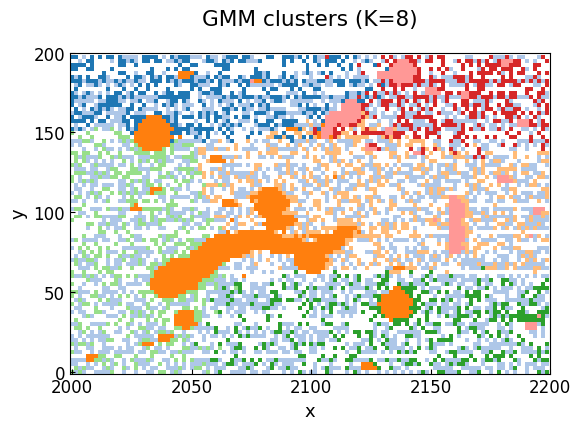

In [321]:
plot_fullframe_clusters_3(
    idx_yx,
    best["labels"],
    frame_size=cut_ccd1.shape,
    title=f"GMM clusters (K={best['K']})"
)

In [330]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_fullframe_clusters_4(idx_yx, labels, frame_size=(320, 640),
                              title=None, keep_cluster=None):
    H, W = frame_size

    # ---- optional: keep only one (or a few) cluster IDs ----
    if keep_cluster is not None:
        keep_cluster = np.atleast_1d(keep_cluster)
        mask = np.isin(labels, keep_cluster)
        idx_yx = idx_yx[mask]
        labels = labels[mask]

    y = idx_yx[:, 0]
    x = idx_yx[:, 1]

    # ---- Build an image where each pixel stores its cluster label ----
    img = np.full((H, W), -1, dtype=int)   # background = -1
    img[y, x] = labels

    # ---- Create color map: background white, clusters colored ----
    unique_labels = np.unique(labels)
    n_colors = unique_labels.max() + 1

    base_cmap = plt.cm.tab20(np.linspace(0, 1, max(n_colors, 20)))
    colors = np.vstack([[1, 1, 1, 1], base_cmap[:n_colors]])
    cmap = ListedColormap(colors)

    img_plot = img + 1  # background goes to 0

    # ---- Plot as filled square pixels ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.imshow(img_plot, origin='lower', cmap=cmap, interpolation='none')

    # OVERRIDE AXIS LABELS (NOT ZOOMING!)
    xticks = np.linspace(0, W, 5)
    yticks = np.linspace(0, H, 5)

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    ax.set_xticklabels(np.linspace(2000, 2200, 5, dtype=int))
    ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int))

    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title if title else "GMM clusters")

    plt.tight_layout()
    plt.show()


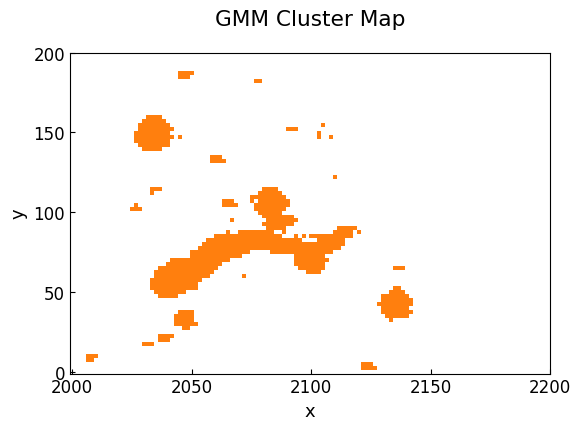

In [331]:
plot_fullframe_clusters_4(
    idx_yx,
    best["labels"],
    frame_size=(80, 120),        # whatever frame_size you were using
    title=f"GMM Cluster Map",
    keep_cluster=2                # <- the cluster ID you want to show
)

In [334]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_fullframe_clusters_5(idx_yx, labels, frame_size=(320, 640),
                              title=None, keep_cluster=None, keep_clusters=None):

    # --- support BOTH names (old: keep_cluster, new: keep_clusters) ---
    if keep_clusters is None:
        keep_clusters = keep_cluster   # maps old argument to new one

    H, W = frame_size

    # --- optional filtering of cluster IDs ---
    if keep_clusters is not None:
        keep_clusters = np.atleast_1d(keep_clusters)
        mask = np.isin(labels, keep_clusters)
        idx_yx = idx_yx[mask]
        labels = labels[mask]

    y = idx_yx[:, 0]
    x = idx_yx[:, 1]

    # --- build label image ---
    img = np.full((H, W), -1, dtype=int)
    img[y, x] = labels

    # --- colormap (same as before) ---
    unique_labels = np.unique(labels)
    n_colors = unique_labels.max() + 1

    base_cmap = plt.cm.tab20(np.linspace(0, 1, max(n_colors, 20)))
    colors = np.vstack([[1,1,1,1], base_cmap[:n_colors]])
    cmap = ListedColormap(colors)

    img_plot = img + 1

    # --- plot ---
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.imshow(img_plot, origin='lower', cmap=cmap, interpolation='none')

    # --- axis relabeling (same as before) ---
    xticks = np.linspace(0, W, 5)
    yticks = np.linspace(0, H, 5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    ax.set_xticklabels(np.linspace(2000, 2200, 5, dtype=int))
    ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int))

    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title if title else "GMM clusters")

    plt.tight_layout()
    plt.show()


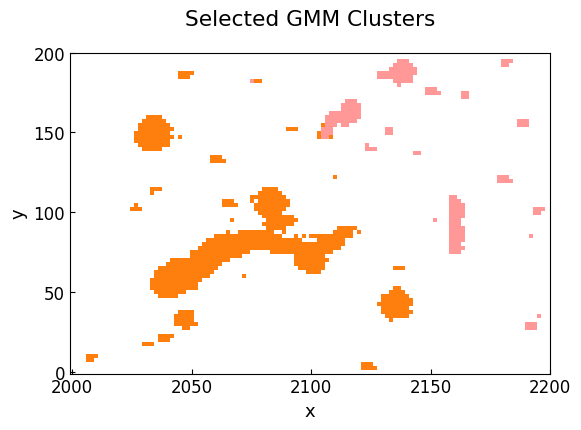

In [339]:
plot_fullframe_clusters_5(
    idx_yx,
    best["labels"],
    frame_size=(80, 120),
    title="Selected GMM Clusters",
    keep_clusters=[2, 7]
)


In [340]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import label as cc_label   # connected components

def plot_cluster_blobs(idx_yx, labels, frame_size=(320, 640),
                       title=None, cluster_id=2):
    H, W = frame_size

    # ---- keep only pixels from the chosen cluster ----
    mask = (labels == cluster_id)
    idx_yx_c = idx_yx[mask]

    if idx_yx_c.size == 0:
        print(f"No pixels found for cluster {cluster_id}")
        return

    y = idx_yx_c[:, 0]
    x = idx_yx_c[:, 1]

    # ---- binary image for this cluster ----
    img = np.zeros((H, W), dtype=int)
    img[y, x] = 1  # 1 where cluster_id is present

    # ---- connected components (each blob gets its own id) ----
    structure = np.ones((3, 3), dtype=int)  # 8-connectivity
    labeled, n_blobs = cc_label(img, structure=structure)
    print(f"Found {n_blobs} blobs in cluster {cluster_id}")

    # ---- colormap: background white, one color per blob ----
    colors = [[1, 1, 1, 1]]  # background
    base = plt.cm.tab20(np.linspace(0, 1, max(n_blobs, 20)))
    colors.extend(base[:n_blobs])
    cmap = ListedColormap(colors)

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.imshow(labeled, origin='lower', cmap=cmap, interpolation='none')

    # same fake CCD axis labels as before
    xticks = np.linspace(0, W, 5)
    yticks = np.linspace(0, H, 5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(np.linspace(2000, 2200, 5, dtype=int))
    ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int))

    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title if title else f"GMM cluster {cluster_id} blobs")

    plt.tight_layout()
    plt.show()


Found 23 blobs in cluster 2


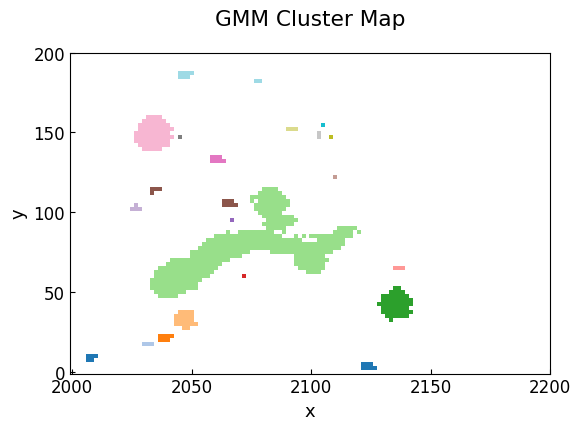

In [341]:
plot_cluster_blobs(
    idx_yx,
    best["labels"],
    frame_size=(80, 120),        # whatever you used before
    title="GMM Cluster Map",
    cluster_id=2
)


In [345]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import label as cc_label   # connected components

def plot_cluster_blobs_2(idx_yx, labels, frame_size=(320, 640),
                       title=None, cluster_id=None, cluster_ids=None):
    H, W = frame_size

    # ---- support single or multiple cluster ids ----
    if cluster_ids is None:
        cluster_ids = cluster_id
    if cluster_ids is None:
        # nothing specified → use all labels
        cluster_ids = np.unique(labels)

    cluster_ids = np.atleast_1d(cluster_ids)

    # ---- keep only pixels from the chosen cluster(s) ----
    mask = np.isin(labels, cluster_ids)
    idx_yx_c = idx_yx[mask]

    if idx_yx_c.size == 0:
        print(f"No pixels found for clusters {cluster_ids}")
        return

    y = idx_yx_c[:, 0]
    x = idx_yx_c[:, 1]

    # ---- binary image for these clusters ----
    img = np.zeros((H, W), dtype=int)
    img[y, x] = 1  # 1 where selected clusters are present

    # ---- connected components (each blob gets its own id) ----
    structure = np.ones((3, 3), dtype=int)  # 8-connectivity
    labeled, n_blobs = cc_label(img, structure=structure)
    print(f"Found {n_blobs} blobs in clusters {cluster_ids}")

    # ---- colormap: background white, one color per blob ----
    colors = [[1, 1, 1, 1]]  # background
    base = plt.cm.tab20(np.linspace(0, 1, max(n_blobs, 20)))
    colors.extend(base[:n_blobs])
    cmap = ListedColormap(colors)

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.imshow(labeled, origin='lower', cmap=cmap, interpolation='none')

    # same fake CCD axis labels as before
    xticks = np.linspace(0, W, 5)
    yticks = np.linspace(0, H, 5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(np.linspace(2000, 2200, 5, dtype=int))
    ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int))

    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if title is None:
        title = f"GMM Clusters"
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


Found 36 blobs in clusters [2 7]


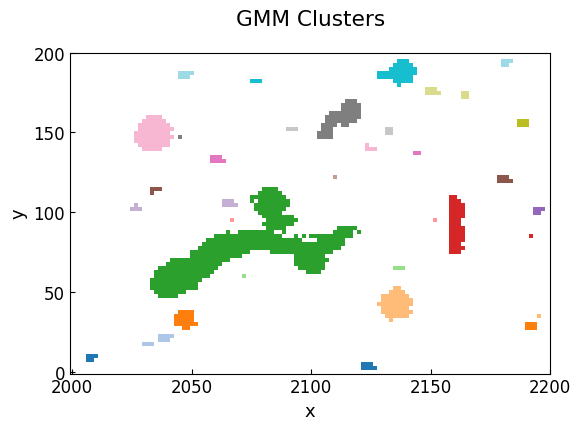

In [346]:
# multiple clusters merged into blobs
plot_cluster_blobs_2(idx_yx, best["labels"], frame_size=(80, 120), cluster_ids=[2, 7])

In [347]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import label as cc_label

def plot_cluster_blobs_with_colorbar(idx_yx, labels, frame_size=(320, 640),
                                     title=None, cluster_id=2):

    H, W = frame_size

    # ---- keep only pixels from the chosen cluster ----
    mask = (labels == cluster_id)
    idx = idx_yx[mask]
    if idx.size == 0:
        print(f"No pixels for cluster {cluster_id}")
        return

    y = idx[:, 0]
    x = idx[:, 1]

    # ---- binary image for that cluster ----
    cluster_img = np.zeros((H, W), dtype=int)
    cluster_img[y, x] = 1

    # ---- connected components (blob IDs) ----
    labeled, n_blobs = cc_label(cluster_img, structure=np.ones((3,3), int))
    print(f"Found {n_blobs} blobs in cluster {cluster_id}")

    # labeled contains integers:
    # 0 = background
    # 1,2,3,... = blobs

    # ---- create a colormap: bg white, blob colors sequential ----
    colors = [(1,1,1,1)]  # background = white
    base = plt.cm.tab20(np.linspace(0, 1, max(n_blobs, 20)))
    for i in range(n_blobs):
        colors.append(base[i % 20])  # cycle if blobs > 20
    cmap = ListedColormap(colors)

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    im = ax.imshow(labeled, origin='lower', cmap=cmap, interpolation='none')

    # ---- axis labels override, same as before ----
    xticks = np.linspace(0, W, 5)
    yticks = np.linspace(0, H, 5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(np.linspace(2000, 2200, 5, dtype=int))
    ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int))

    ax.set_aspect("equal")
    ax.set_xlabel("Column index (x)")
    ax.set_ylabel("Row index (y)")
    ax.set_title(title if title else f"Cluster ID")

    # ---- add colorbar for blob ID ----
    cbar = plt.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
    cbar.set_label("Cluster ID", rotation=90)

    plt.tight_layout()
    plt.show()


Found 23 blobs in cluster 2


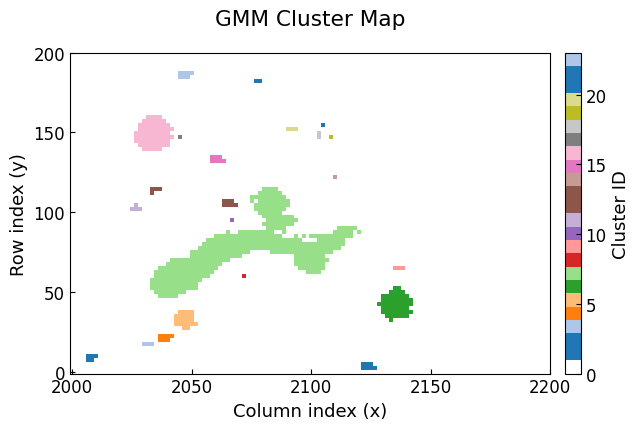

In [348]:
plot_cluster_blobs_with_colorbar(
    idx_yx,
    best["labels"],
    frame_size=(80, 120),   # whatever your cropped size is
    cluster_id=2,
    title="GMM Cluster Map"
)


In [349]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import label as cc_label
from mpl_toolkits.axes_grid1 import make_axes_locatable   # <-- for clean cbar

def plot_cluster_blobs_with_colorbar(idx_yx, labels, frame_size=(320, 640),
                                     title=None, cluster_id=2):

    H, W = frame_size

    # ---- keep only pixels from the chosen cluster ----
    mask = (labels == cluster_id)
    idx = idx_yx[mask]
    if idx.size == 0:
        print(f"No pixels for cluster {cluster_id}")
        return

    y = idx[:, 0]
    x = idx[:, 1]

    # ---- binary image for that cluster ----
    cluster_img = np.zeros((H, W), dtype=int)
    cluster_img[y, x] = 1

    # ---- connected components (blob IDs) ----
    labeled, n_blobs = cc_label(cluster_img, structure=np.ones((3,3), int))
    print(f"Found {n_blobs} blobs in cluster {cluster_id}")

    # ---- your existing color map (unchanged) ----
    colors = [(1,1,1,1)]
    base = plt.cm.tab20(np.linspace(0, 1, max(n_blobs, 20)))
    for i in range(n_blobs):
        colors.append(base[i % 20])
    cmap = ListedColormap(colors)

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    im = ax.imshow(labeled, origin='lower', cmap=cmap, interpolation='none')

    # ---- axis labels override, same as before ----
    xticks = np.linspace(0, W, 5)
    yticks = np.linspace(0, H, 5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(np.linspace(2000, 2200, 5, dtype=int))
    ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int))

    ax.set_aspect("equal")
    ax.set_xlabel("Column index (x)")
    ax.set_ylabel("Row index (y)")
    ax.set_title(title if title else f"Cluster ID")

    # --------------------------------------------------------
    # CLEAN, ALIGNED COLORBAR (same height as the axes)
    # --------------------------------------------------------
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.15)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Cluster ID", rotation=90)

    plt.tight_layout()
    plt.show()


Found 23 blobs in cluster 2


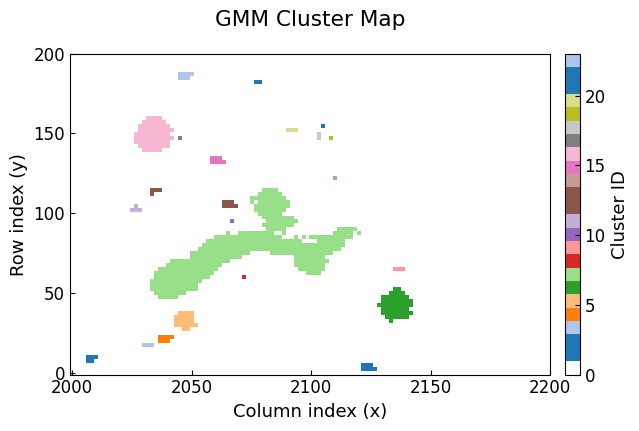

In [350]:
plot_cluster_blobs_with_colorbar(
    idx_yx,
    best["labels"],
    frame_size=(80, 120),   # whatever your cropped size is
    cluster_id=2,
    title="GMM Cluster Map"
)

In [375]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import label as cc_label
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_cluster_blobs_with_colorbar2(idx_yx, labels, frame_size=(320, 640),
                                     title=None, cluster_id=None, cluster_ids=None,
                                     figsize=(6,4)):   # <-- NEW: controls final shape

    H, W = frame_size

    # ---- support single or multiple cluster IDs ----
    if cluster_ids is None:
        cluster_ids = cluster_id
    if cluster_ids is None:
        cluster_ids = np.unique(labels)
    cluster_ids = np.atleast_1d(cluster_ids)

    # ---- keep only pixels from the chosen clusters ----
    mask = np.isin(labels, cluster_ids)
    idx = idx_yx[mask]
    if idx.size == 0:
        print(f"No pixels for clusters {cluster_ids}")
        return

    y = idx[:, 0]
    x = idx[:, 1]

    cluster_img = np.zeros((H, W), dtype=int)
    cluster_img[y, x] = 1

    # ---- connected components ----
    labeled, n_blobs = cc_label(cluster_img, structure=np.ones((3,3), int))
    print(f"Found {n_blobs} blobs in clusters {cluster_ids}")

    # ---- unique blob colors ----
    colors = [(1,1,1,1)]
    tabA = plt.cm.tab20(np.linspace(0,1,20))
    tabB = plt.cm.tab20b(np.linspace(0,1,20))
    tabC = plt.cm.tab20c(np.linspace(0,1,20))
    palette = np.vstack([tabA, tabB, tabC])

    if n_blobs <= palette.shape[0]:
        colors.extend(palette[:n_blobs])
    else:
        extra = np.random.rand(n_blobs - palette.shape[0], 4)
        extra[:,3] = 1
        colors.extend(palette)
        colors.extend(extra)

    cmap = ListedColormap(colors)

    # ---- PLOT ----
    fig, ax = plt.subplots(figsize=figsize)   # <-- HERE: final rendered shape
    im = ax.imshow(labeled, origin='lower', cmap=cmap, interpolation='none')

    # ---- axis labels override ----
    xticks = np.linspace(0, W, 5)
    yticks = np.linspace(0, H, 5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(np.linspace(2000, 2200, 5, dtype=int))
    ax.set_yticklabels(np.linspace(0, 200, 5, dtype=int))

    ax.set_aspect("equal")   # keeps pixel squares correct
    ax.set_xlabel("Column index (x)")
    ax.set_ylabel("Row index (y)")

    # ---- aligned colorbar ----
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Cluster ID", rotation=90)

    plt.tight_layout()

    # ---- save ----
    fig.savefig("GMM_cluster_img.pdf", format="pdf", dpi=300)

    plt.show()




Found 36 blobs in clusters [2 7]


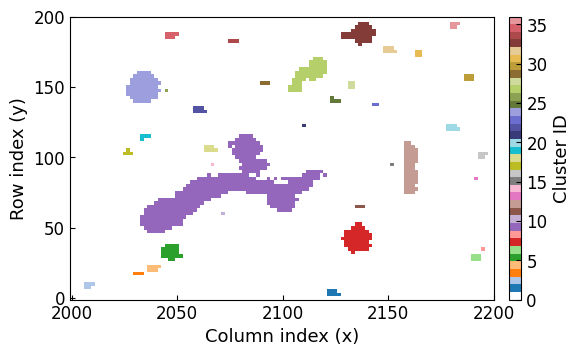

In [379]:
# multiple clusters merged into blobs
plot_cluster_blobs_with_colorbar2(
    idx_yx, best["labels"],
    frame_size=(80, 120),
    cluster_ids=[2, 7],
    figsize=(6,6) 
)


### waders

In [298]:
import uproot

In [299]:
file = "panaSKImg_clustersRec_avg_Image_8_Low_Temp_109_20251117_102727_2_ext1 (1).root"

In [300]:
with uproot.open(file) as f:
    print(f.keys())

['clustersRec;1', 'info;1', 'process_config;1']


In [301]:
clustersRec_tree = f["clustersRec"]

In [302]:
df = clustersRec_tree.arrays(library="pd")

In [303]:
try:
    import awkward as ak
except Exception:
    ak = None

def to_list_maybe(x):
    # Handle common array-likes
    if isinstance(x, (list, tuple, np.ndarray, pd.Series)):
        return list(x)
    # Awkward arrays
    if ak is not None:
        try:
            return ak.to_list(x)
        except Exception:
            pass
    # Some awkward objects have .to_list()
    if hasattr(x, "to_list"):
        try:
            return x.to_list()
        except Exception:
            pass
    # Not an array -> return None so we can repeat later
    return None

# --- Choose columns (drop the blockers) ---
cols = [c for c in df.columns if c not in ["RUNID", "Nclusters"]]

# Use the first row (you said there's 1 row)
row = df.iloc[0]

# Find target length (e.g., 991) from the first array-like column
N = None
for c in cols:
    seq = to_list_maybe(row[c])
    if seq is not None:
        N = len(seq)
        break
if N is None:
    raise ValueError("Couldn't find any array-like columns to expand.")

# Build dict of columns -> sequences (repeat scalars)
data = {}
for c in cols:
    seq = to_list_maybe(row[c])
    if seq is None:
        # scalar: repeat it N times
        data[c] = [row[c]] * N
    else:
        data[c] = seq

df_expanded = pd.DataFrame(data).reset_index(drop=True)

print(df_expanded.shape)  
df_expanded.head()

(1221, 57)


,DX,DY,Energy,Energy_AVG,Energy_PS,Npix,PosX,PosY,Qmax,QmaxX,...,readout_end,readout_start,seed_nsig_delta,seed_nsig_max,seed_nsig_min,seed_nsig_pixels,sigma_seed_eV,wSTD_X,wSTD_XY,wSTD_Y
0,13.0,3.0,0.551589,-657.085327,198.070648,21,438.261169,1.453099,0.045356,437.0,...,1.763462e+09,1.763404e+09,22.825567,33.671371,10.845805,"[14.133325576782227, 13.583669662475586, 19.94...",1.347009,2.909075,2.110190,0.665645
1,9.0,10.0,6.524772,16.563927,2342.986084,57,921.312500,189.578644,0.456312,921.0,...,1.763462e+09,1.763404e+09,328.148346,338.759766,10.611405,"[11.457945823669434, 11.269667625427246, 10.86...",1.347009,1.523130,1.515790,1.508413
2,8.0,8.0,23.984516,6735.193359,8612.622070,46,1398.469727,187.493744,2.389755,1398.0,...,1.763462e+09,1.763404e+09,1763.489502,1774.119995,10.630532,"[23.964277267456055, 15.71530818939209, 13.569...",1.347009,1.149206,1.132223,1.114982
3,3.0,2.0,5.822162,1886.595825,2090.685547,5,1733.095947,184.680054,3.588612,1733.0,...,1.763462e+09,1.763404e+09,2650.236084,2664.134277,13.898038,"[1257.5697021484375, 125.31927490234375, 2664....",1.347009,0.305172,0.394151,0.466454
4,4.0,1.0,1.285796,298.882690,461.717712,4,534.557800,1.000000,0.631432,535.0,...,1.763462e+09,1.763404e+09,443.776703,468.766083,24.989376,"[24.989376068115234, 416.4757080078125, 468.76...",1.347009,0.626012,0.442658,0.000000


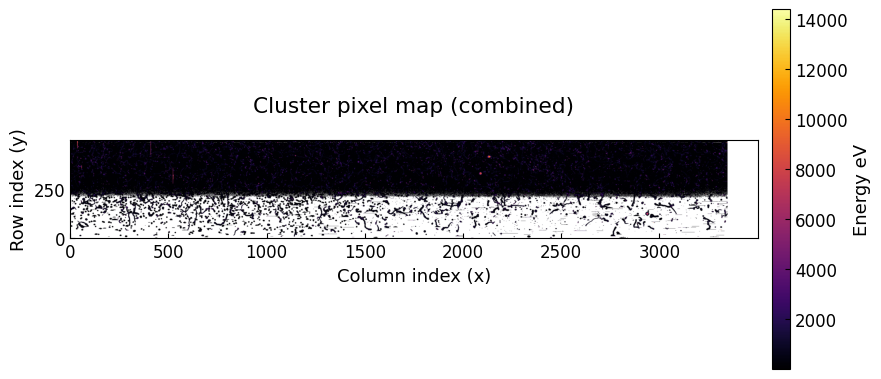

In [304]:
H, W = 500, 3500

# initialize blank image (white background via NaNs)
img = np.full((H, W), np.nan)

# fill in clusters
for _, row in df_expanded.iterrows():
    xs = np.array(row["pixels_x"], dtype=int)
    ys = np.array(row["pixels_y"], dtype=int)
    Es = np.array(row["pixels_E_PS"], dtype=float)

    # ensure coordinates are in range
    mask = (xs >= 0) & (xs < W) & (ys >= 0) & (ys < H)
    xs, ys, Es = xs[mask], ys[mask], Es[mask]

    img[ys, xs] = Es

# make a copy of the colormap and set NaN (bad) color to white
cmap = plt.colormaps["inferno"].copy()
cmap.set_bad("white")

plt.figure(figsize=(9, 4.5))
im = plt.imshow(img, cmap=cmap, origin="lower")  # <-- y=0 at bottom
plt.colorbar(im, label="Energy eV", fraction=0.025, pad=0.02)
plt.title("Cluster pixel map (combined)")
plt.xlabel("Column index (x)")
plt.ylabel("Row index (y)")
plt.tight_layout()
plt.show()

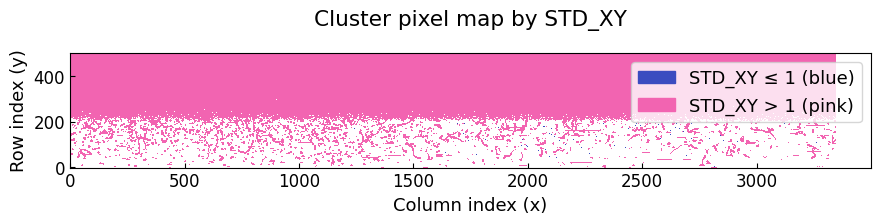

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

H, W = 500, 3500

# label map: 0 = STD_XY <= 1, 1 = STD_XY > 1, NaN = background
labels = np.full((H, W), np.nan, dtype=float)

for _, row in df_expanded.iterrows():
    xs = np.array(row["pixels_x"], dtype=int)
    ys = np.array(row["pixels_y"], dtype=int)

    # keep in-bounds
    mask = (xs >= 0) & (xs < W) & (ys >= 0) & (ys < H)
    xs, ys = xs[mask], ys[mask]

    if row["STD_XY"] <= 1.0:
        labels[ys, xs] = 0.0
    else:
        labels[ys, xs] = 1.0

# blue + pink colormap
cmap = ListedColormap([
    "#3B4CC0",  # blue
    "#F264B1",  # pink
])
cmap.set_bad("white")  # background

plt.figure(figsize=(9, 4.5))
plt.imshow(labels, origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation="none")

plt.title("Cluster pixel map by STD_XY")
plt.xlabel("Column index (x)")
plt.ylabel("Row index (y)")

# legend
handles = [
    Patch(color="#3B4CC0", label="STD_XY ≤ 1 (blue)"),
    Patch(color="#F264B1", label="STD_XY > 1 (pink)"),
]
plt.legend(handles=handles, loc="upper right", frameon=True)

plt.tight_layout()
plt.show()


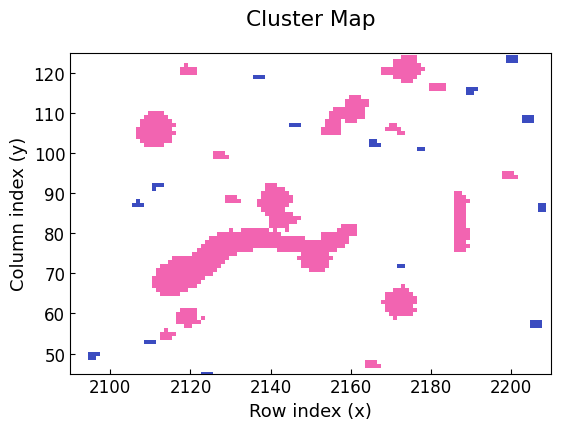

In [308]:
plt.figure(figsize=(9, 4.5))
plt.imshow(labels, origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation="none")

plt.title("Cluster Map")
plt.xlabel("Row index (x)")
plt.ylabel("Column index (y)")

# -------------------------------
# ZOOM TO THE REQUESTED CCD REGION
# -------------------------------
plt.xlim(2090, 2210)   # x range
plt.ylim(45, 125)       # y range

plt.tight_layout()
plt.show()


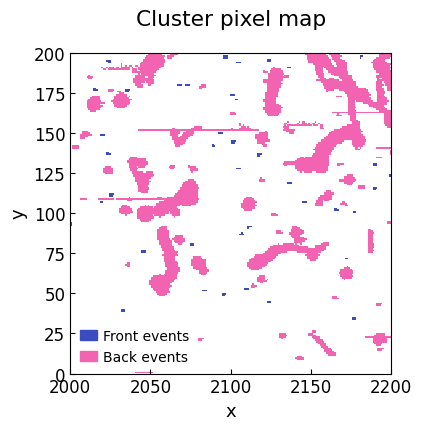

In [179]:
plt.figure(figsize=(9, 4.5))
plt.imshow(labels, origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation="none")

plt.title("Cluster pixel map")
plt.xlabel("x")
plt.ylabel("y")

# Zoom region
plt.xlim(2000, 2200)
plt.ylim(0, 200)

# Clean legend in lower-left
from matplotlib.patches import Patch
clean_handles = [
    Patch(color="#3B4CC0", label="Front events"),
    Patch(color="#F264B1", label="Back events"),
]

plt.legend(
    handles=clean_handles,
    loc="lower left",
    frameon=False,
    fontsize=10,
    borderpad=0.2,
    handlelength=1.2,
    handletextpad=0.5
)

plt.tight_layout()
plt.show()


In [172]:
print(df_expanded[df_expanded["STD_XY"] < 1]["STD_XY"])

3       0.894427
7       0.957427
14      0.957427
16      0.894427
18      0.816497
          ...   
1203    0.816497
1204    0.957427
1215    0.816497
1218    0.894427
1219    0.816497
Name: STD_XY, Length: 301, dtype: float64


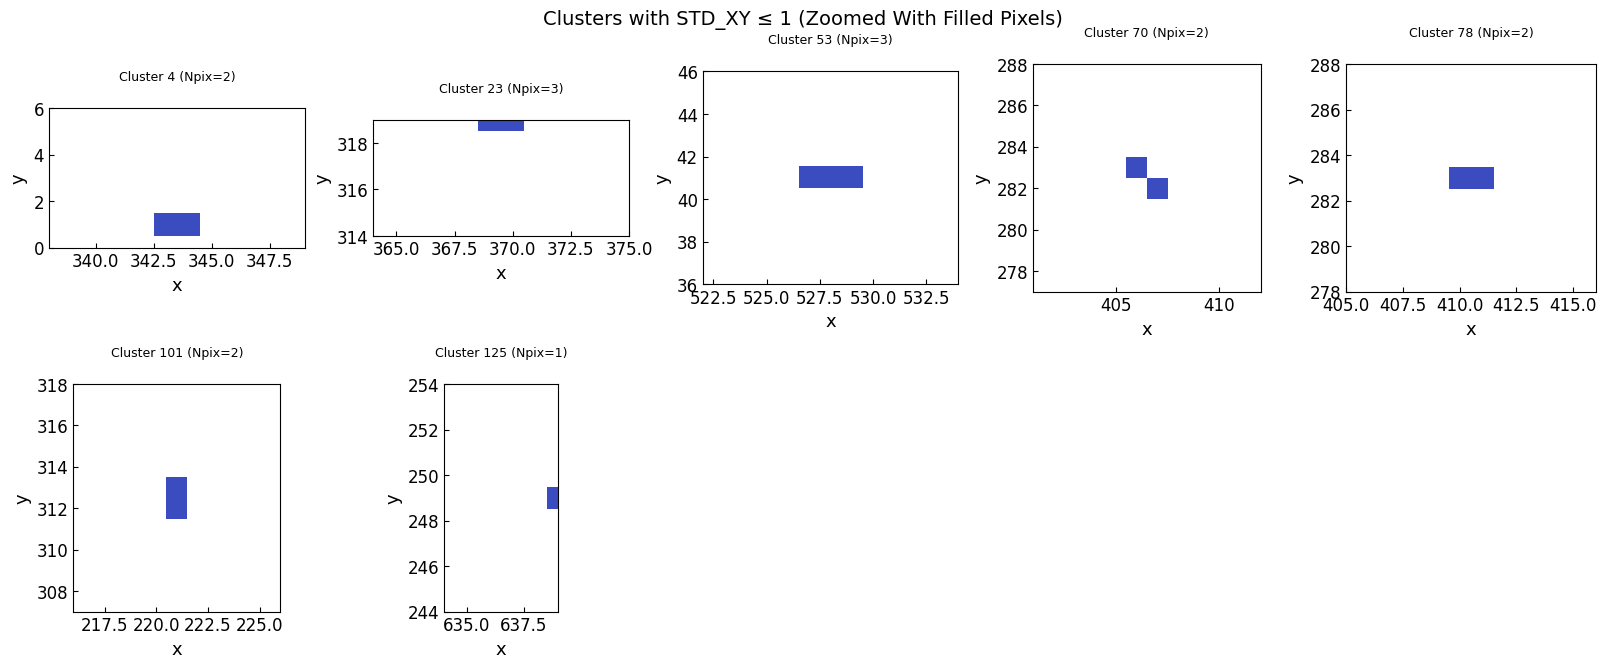

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math

H, W = 320, 640  # CCD size

# select low-spread clusters
blue_df = df_expanded[df_expanded["STD_XY"] <= 1.0].copy()

if blue_df.empty:
    print("No clusters with STD_XY <= 1.0 found.")
else:
    n_clusters = len(blue_df)
    ncols = 5
    nrows = math.ceil(n_clusters / ncols)

    fig, axes = plt.subplots(
        nrows, ncols, figsize=(3.2 * ncols, 3.2 * nrows), constrained_layout=True
    )
    axes = np.array(axes).ravel()

    fig.suptitle("Clusters with STD_XY ≤ 1 (Zoomed With Filled Pixels)", fontsize=14, y=1.02)

    # blue colormap (white background)
    cmap = ListedColormap(["white", "#3B4CC0"])

    pad = 5  # margin around each cluster

    for ax, (_, row) in zip(axes, blue_df.iterrows()):
        xs = np.asarray(row["pixels_x"], int)
        ys = np.asarray(row["pixels_y"], int)

        # keep valid pixels
        m = (xs >= 0) & (xs < W) & (ys >= 0) & (ys < H)
        xs, ys = xs[m], ys[m]

        # make a blank CCD image for this cluster
        img = np.zeros((H, W), dtype=int)
        img[ys, xs] = 1  # fill pixels in blue

        # show filled-pixel image
        ax.imshow(img, origin="lower", cmap=cmap, interpolation="none")

        # zoom to cluster bounding box
        x_min, x_max = xs.min() - pad, xs.max() + pad
        y_min, y_max = ys.min() - pad, ys.max() + pad
        ax.set_xlim(max(0, x_min), min(W-1, x_max))
        ax.set_ylim(max(0, y_min), min(H-1, y_max))

        cid = row["cluster_id"] if "cluster_id" in row else row.name
        ax.set_title(f"Cluster {cid} (Npix={row['Npix']})", fontsize=9)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect("equal")

    # hide unused axes
    for ax in axes[len(blue_df):]:
        ax.axis("off")

    plt.show()


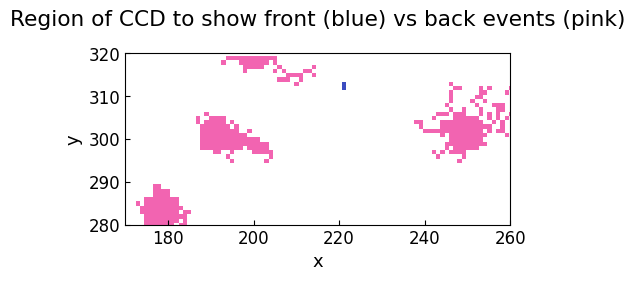

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

H, W = 320, 640  # CCD size

# full CCD label map
# 0 = background, 1 = STD_XY < 1 (blue), 2 = STD_XY >= 1 (pink)
labels = np.zeros((H, W), dtype=int)

for _, row in df_expanded.iterrows():
    xs = np.asarray(row["pixels_x"], int)
    ys = np.asarray(row["pixels_y"], int)

    # keep only pixels that land on the CCD
    m = (xs >= 0) & (xs < W) & (ys >= 0) & (ys < H)
    xs, ys = xs[m], ys[m]

    if row["STD_XY"] < 1.0:
        labels[ys, xs] = 1
    else:
        labels[ys, xs] = 2

# region of interest
x_min, x_max = 170, 260
y_min, y_max = 280, 320

# colormap: white background, blue for <1, pink for >=1
cmap = ListedColormap([
    "white",    # 0
    "#3B4CC0",  # 1 = STD_XY < 1
    "#F264B1",  # 2 = STD_XY >= 1
])

plt.figure(figsize=(5, 5))
plt.imshow(labels, origin="lower", cmap=cmap, vmin=0, vmax=2, interpolation="none")

# zoom into the requested CCD chunk (clipped to CCD bounds automatically)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title("Region of CCD to show front (blue) vs back events (pink)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


# RUN UP TO HERE

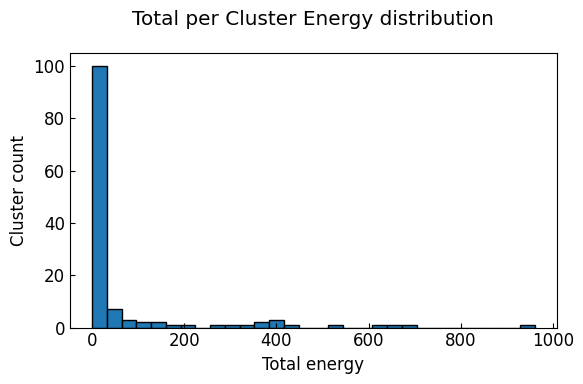

In [ ]:
E = df_expanded["Energy"].to_numpy() 

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(E, bins=30, edgecolor="black")  # adjust bins if you like

ax.set_xlabel("Total energy")
ax.set_ylabel("Cluster count")
ax.set_title(f"Total per Cluster Energy distribution")

plt.tight_layout()
plt.show()

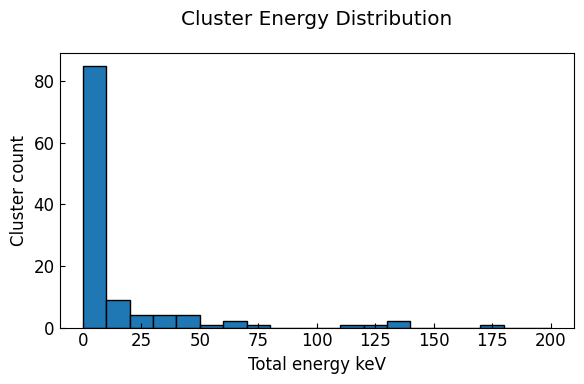

In [ ]:
# keep only clusters with energy ≤ 200
E_cut = E[E <= 200]

fig, ax = plt.subplots(figsize=(6, 4))

# 20 fine-grained bins from 0 to 200
ax.hist(E_cut, bins=np.linspace(0, 200, 21), edgecolor="black")

ax.set_xlabel("Total energy keV")
ax.set_ylabel("Cluster count")
ax.set_title("Cluster Energy Distribution")

plt.tight_layout()
plt.show()


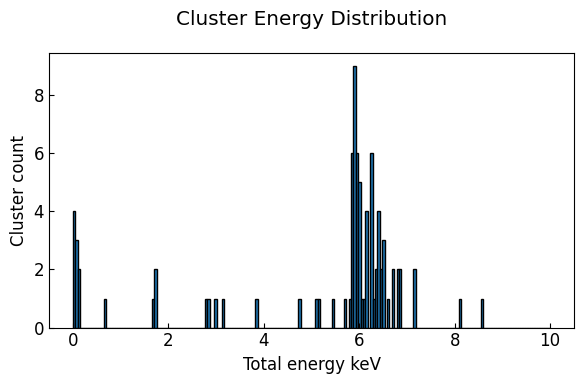

In [ ]:
# keep only clusters with energy ≤ 200
E_cut = E[E <= 20]

fig, ax = plt.subplots(figsize=(6, 4))

# 20 fine-grained bins from 0 to 200
ax.hist(E_cut, bins=np.linspace(0, 10, 200), edgecolor="black")

ax.set_xlabel("Total energy keV")
ax.set_ylabel("Cluster count")
ax.set_title("Cluster Energy Distribution")

plt.tight_layout()
plt.show()

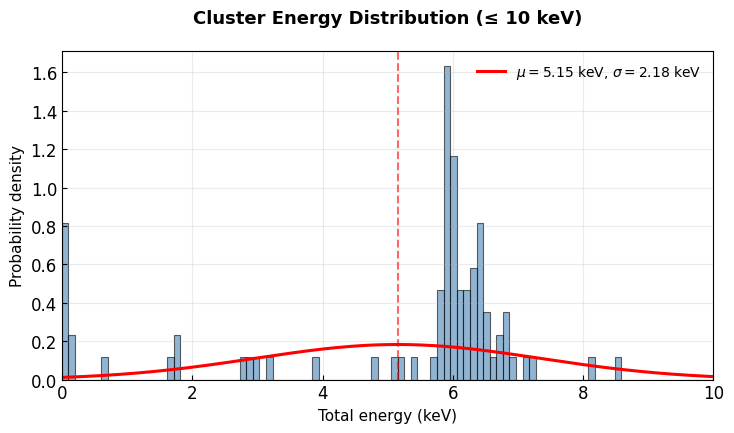

In [ ]:
from scipy.stats import norm

lo, hi = 0.0, 10.0  # keV range
E_cut = E[(E >= lo) & (E <= hi)]

# --- Histogram configuration ---
bins = np.linspace(lo, hi, 100)  

fig, ax = plt.subplots(figsize=(7.5, 4.5))

# Histogram as a normalized PDF (for Gaussian overlay)
counts, bin_edges, _ = ax.hist(
    E_cut, bins=bins, density=True, alpha=0.6,
    color="steelblue", edgecolor="black", linewidth=0.8
)

# --- Gaussian fit ---
mu, sigma = norm.fit(E_cut)
x = np.linspace(lo, hi, 1000)
y = norm.pdf(x, mu, sigma)
ax.plot(x, y, "r-", lw=2.2, label=rf"$\mu={mu:.2f}$ keV, $\sigma={sigma:.2f}$ keV")

# --- Plot styling ---
ax.set_xlim(lo, hi)
ax.set_xlabel("Total energy (keV)", fontsize=11)
ax.set_ylabel("Probability density", fontsize=11)
ax.set_title("Cluster Energy Distribution (≤ 10 keV)", fontsize=13, weight="bold")
ax.legend(frameon=False, fontsize=10)
ax.grid(alpha=0.25)

# --- Annotate peak visually ---
ax.axvline(mu, color="red", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


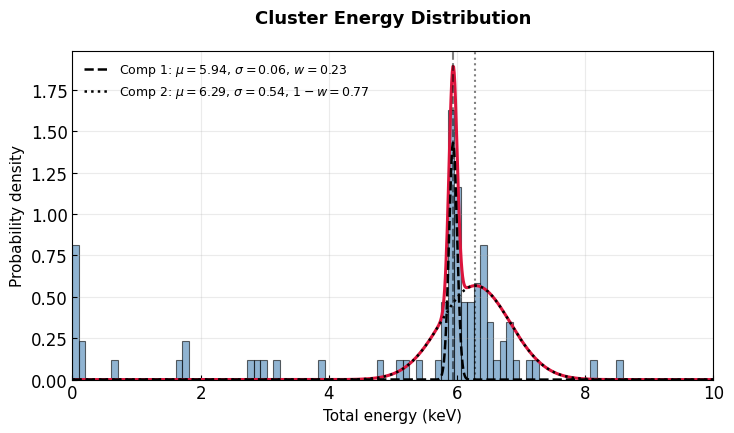

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# --- Data cut ---
lo, hi = 0.0, 10.0       # display range
fit_lo, fit_hi = 2.0, 10.0  # fit range
E_cut = E[(E >= lo) & (E <= hi)]

# --- Histogram configuration ---
bins = np.linspace(lo, hi, 100)
fig, ax = plt.subplots(figsize=(7.5, 4.5))

# Histogram as a normalized PDF (for mixture overlay)
counts, bin_edges, _ = ax.hist(
    E_cut, bins=bins, density=True, alpha=0.6,
    color="steelblue", edgecolor="black", linewidth=0.8
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Restrict data to fit range
mask_fit = (bin_centers >= fit_lo) & (bin_centers <= fit_hi)
x_fit = bin_centers[mask_fit]
y_fit = counts[mask_fit]

# --- Two-Gaussian mixture model ---
def two_gauss_pdf(x, w, mu1, sigma1, mu2, sigma2):
    w = np.clip(w, 1e-6, 1 - 1e-6)
    sigma1 = np.maximum(sigma1, 1e-6)
    sigma2 = np.maximum(sigma2, 1e-6)
    return w * norm.pdf(x, mu1, sigma1) + (1 - w) * norm.pdf(x, mu2, sigma2)

# Initial guesses based only on fit region
E_fit = E[(E >= fit_lo) & (E <= fit_hi)]
p30, p50, p70 = np.percentile(E_fit, [30, 50, 70])
std_all = np.std(E_fit) if np.std(E_fit) > 0 else (fit_hi - fit_lo) / 10
std1 = np.std(E_fit[E_fit <= p50]) if np.any(E_fit <= p50) else std_all / 2
std2 = np.std(E_fit[E_fit >  p50]) if np.any(E_fit >  p50) else std_all / 2

p0 = [0.5, p30, max(std1, 1e-3), p70, max(std2, 1e-3)]
bounds = ([0.0, fit_lo, 1e-6, fit_lo, 1e-6], [1.0, fit_hi, fit_hi - fit_lo, fit_hi, fit_hi - fit_lo])

# Fit to histogram density at bin centers (2–10 keV only)
popt, pcov = curve_fit(two_gauss_pdf, x_fit, y_fit, p0=p0, bounds=bounds)
w, mu1, s1, mu2, s2 = popt

# Sort components so mu1 < mu2
if mu1 > mu2:
    mu1, mu2 = mu2, mu1
    s1, s2   = s2, s1
    w        = 1 - w

# --- Plot mixture & components ---
x = np.linspace(lo, hi, 1000)
mix = two_gauss_pdf(x, w, mu1, s1, mu2, s2)
comp1 = w * norm.pdf(x, mu1, s1)
comp2 = (1 - w) * norm.pdf(x, mu2, s2)

ax.plot(x, mix, "-", lw=2.2, color="crimson")
ax.plot(x, comp1, "--", lw=1.8, color="black", label=fr"Comp 1: $\mu={mu1:.2f}$, $\sigma={s1:.2f}$, $w={w:.2f}$")
ax.plot(x, comp2, ":",  lw=1.8, color="black", label=fr"Comp 2: $\mu={mu2:.2f}$, $\sigma={s2:.2f}$, $1-w={1-w:.2f}$")

# Mark component means
ax.axvline(mu1, color="black", linestyle="--", alpha=0.5)
ax.axvline(mu2, color="black", linestyle=":",  alpha=0.5)

# --- Plot styling ---
ax.set_xlim(lo, hi)
ax.set_xlabel("Total energy (keV)", fontsize=11)
ax.set_ylabel("Probability density", fontsize=11)
ax.set_title("Cluster Energy Distribution", fontsize=13, weight="bold")
ax.legend(frameon=False, fontsize=9)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()



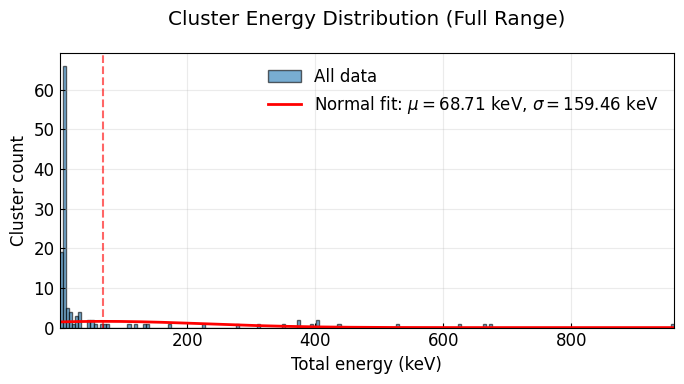

In [ ]:
# choose bin range automatically based on data spread
lo, hi = np.min(E), np.max(E)
bins = np.linspace(lo, hi, 200)

# --- fit Gaussian (MLE) ---
mu, sigma = norm.fit(E)

# --- build Gaussian scaled to histogram COUNTS ---
bin_width = bins[1] - bins[0]
x = np.linspace(lo, hi, 1000)
y_counts = norm.pdf(x, mu, sigma) * len(E) * bin_width

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(E, bins=bins, edgecolor="black", alpha=0.6, label="All data")
ax.plot(x, y_counts, "r-", lw=2, label=rf"Normal fit: $\mu={mu:.2f}$ keV, $\sigma={sigma:.2f}$ keV")
ax.axvline(mu, color="r", ls="--", alpha=0.6)

# labels and aesthetics
ax.set_xlim(lo, hi)
ax.set_xlabel("Total energy (keV)")
ax.set_ylabel("Cluster count")
ax.set_title("Cluster Energy Distribution (Full Range)")
ax.legend(frameon=False)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

In [ ]:
len(E)

130

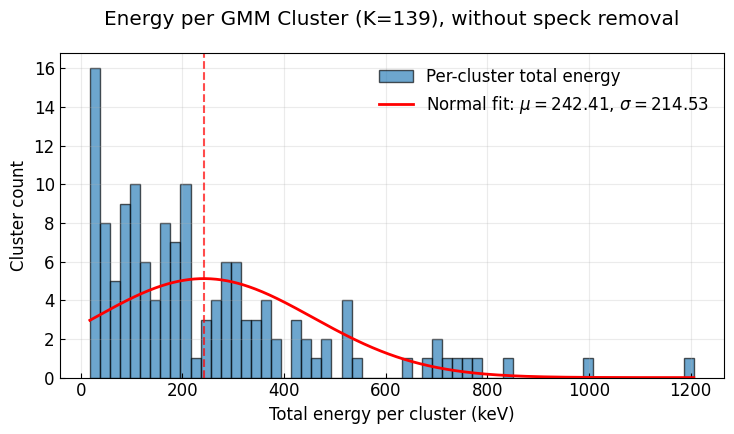

[per-cluster energy] mean=242.414 keV, std=214.534 keV, min=18.021, max=1206.358, K=139


In [ ]:
from scipy.stats import norm

# ---- 1) choose best GMM by BIC (you already have 'results' from fit_gmms_over_K) ----
best = results_thresh[0]   # because you sorted by BIC in your helper
gmm     = best["model"]
labels  = best["labels"]
scaler  = best["scaler"]

# ---- 2) total energy per cluster (E is the 3rd column of X_raw) ----
# X_raw shape: (N, 3) with columns [x, y, E] in ORIGINAL units
E = X_raw_thresh[:, 2]

K = gmm.n_components
# totals[k] = sum of energies for all points assigned to cluster k
totals = np.zeros(K, dtype=float)
np.add.at(totals, labels, E)

# ---- 3) histogram of per-cluster total energies + Gaussian overlay (scaled to counts) ----
# choose binning automatically; adjust as you like (e.g., np.linspace(0, 10, 41))
num_bins = max(10, min(60, K))   # simple heuristic: up to 60 bins
lo, hi = float(np.min(totals)), float(np.max(totals))
bins = np.linspace(lo, hi, num_bins + 1)

# fit Gaussian to the *totals* distribution
mu, sigma = norm.fit(totals)

# scale Gaussian to histogram counts
bin_width = bins[1] - bins[0]
x = np.linspace(lo, hi, 1000)
y_counts = norm.pdf(x, mu, sigma) * len(totals) * bin_width

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.hist(totals, bins=bins, edgecolor="black", alpha=0.65, label="Per-cluster total energy")
ax.plot(x, y_counts, "r-", lw=2.0,
        label=rf"Normal fit: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$")
ax.axvline(mu, color="r", ls="--", alpha=0.7)

ax.set_xlabel("Total energy per cluster (keV)")
ax.set_ylabel("Cluster count")
ax.set_title(f"Energy per GMM Cluster (K={K}), without speck removal")
ax.legend(frameon=False)
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

print(f"[per-cluster energy] mean={mu:.3f} keV, std={sigma:.3f} keV, "
      f"min={totals.min():.3f}, max={totals.max():.3f}, K={K}")


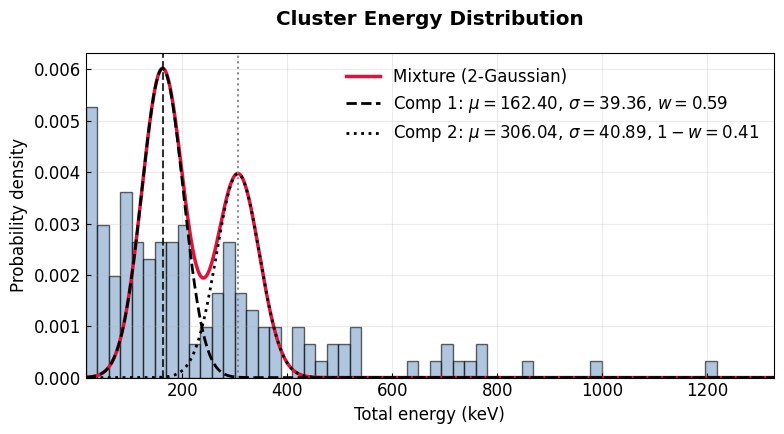

  Comp 1: weight=0.593, mu=162.400, sigma=39.358
  Comp 2: weight=0.407, mu=306.038, sigma=40.892
Fitted on 75 / 139 clusters within 100–400 keV.


In [ ]:
# --- 1) Per-cluster total energies ---
E = X_raw_thresh[:, 2]
K = gmm.n_components
totals = np.zeros(K, float)
np.add.at(totals, labels, E)

# --- 2) Restrict fit to [100, 400] keV ---
fit_lo, fit_hi = 100, 400
mask = (totals >= fit_lo) & (totals <= fit_hi)
totals_fit = totals[mask]

# --- 3) Fit 2-Gaussian model only on this subset ---
X = totals_fit.reshape(-1, 1)
gmm2 = GaussianMixture(n_components=2, covariance_type="full",
                       n_init=10, random_state=0).fit(X)
w = gmm2.weights_.ravel()
m = gmm2.means_.ravel()
s = np.sqrt(gmm2.covariances_.ravel())

# order components by mean for nicer labels
order = np.argsort(m)
w, m, s = w[order], m[order], s[order]

# --- 4) Compute PDFs over the FULL range ---
lo_full, hi_full = max(0.0, totals.min()*0.9), totals.max()*1.1
x = np.linspace(lo_full, hi_full, 1500)
pdf1 = w[0] * norm.pdf(x, m[0], s[0])
pdf2 = w[1] * norm.pdf(x, m[1], s[1])
pdf_mix = pdf1 + pdf2

# --- 5) Plot full histogram and curves ---
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.hist(totals, bins=60, range=(lo_full, hi_full),
        density=True, alpha=0.6, color="#7aa0c9", edgecolor="black")

ax.plot(x, pdf_mix, color="crimson", lw=2.5, label="Mixture (2-Gaussian)")
ax.plot(x, pdf1, "k--", lw=2, label=fr"Comp 1: $\mu={m[0]:.2f}$, $\sigma={s[0]:.2f}$, $w={w[0]:.2f}$")
ax.plot(x, pdf2, "k:",  lw=2, label=fr"Comp 2: $\mu={m[1]:.2f}$, $\sigma={s[1]:.2f}$, $1-w={w[1]:.2f}$")

ax.axvline(m[0], color="k", ls="--", alpha=0.8)
ax.axvline(m[1], color="gray", ls=":", alpha=0.9)

ax.set_title("Cluster Energy Distribution", fontweight="bold")
ax.set_xlabel("Total energy (keV)")
ax.set_ylabel("Probability density")
ax.set_xlim(lo_full, hi_full)
ax.legend(frameon=False, loc="upper right")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

for i, (wi, mi, si) in enumerate(zip(w, m, s), 1):
    print(f"  Comp {i}: weight={wi:.3f}, mu={mi:.3f}, sigma={si:.3f}")
print(f"Fitted on {totals_fit.size} / {totals.size} clusters within 100–400 keV.")



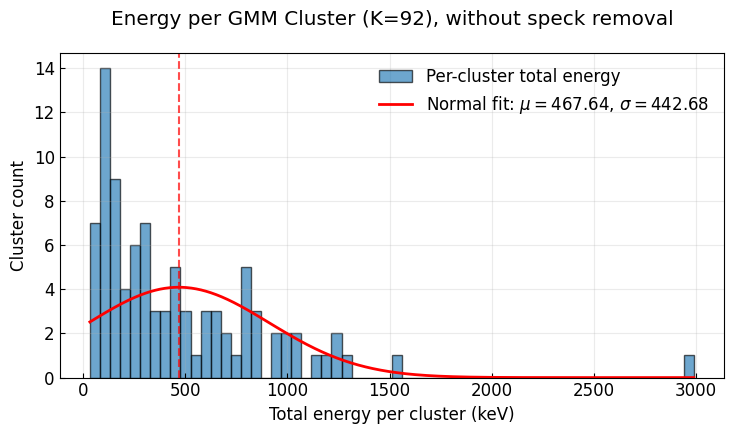

[per-cluster energy] mean=467.643 keV, std=442.684 keV, min=31.809, max=2990.720, K=92


In [ ]:
from scipy.stats import norm

# ---- 1) choose best GMM by BIC (you already have 'results' from fit_gmms_over_K) ----
best = results_cleaned[0]   # because you sorted by BIC in your helper
gmm     = best["model"]
labels  = best["labels"]
scaler  = best["scaler"]

# ---- 2) total energy per cluster (E is the 3rd column of X_raw) ----
# X_raw shape: (N, 3) with columns [x, y, E] in ORIGINAL units
E = X_raw_cleaned[:, 2]

K = gmm.n_components
# totals[k] = sum of energies for all points assigned to cluster k
totals = np.zeros(K, dtype=float)
np.add.at(totals, labels, E)

# ---- 3) histogram of per-cluster total energies + Gaussian overlay (scaled to counts) ----
# choose binning automatically; adjust as you like (e.g., np.linspace(0, 10, 41))
num_bins = max(10, min(60, K))   # simple heuristic: up to 60 bins
lo, hi = float(np.min(totals)), float(np.max(totals))
bins = np.linspace(lo, hi, num_bins + 1)

# fit Gaussian to the *totals* distribution
mu, sigma = norm.fit(totals)

# scale Gaussian to histogram counts
bin_width = bins[1] - bins[0]
x = np.linspace(lo, hi, 1000)
y_counts = norm.pdf(x, mu, sigma) * len(totals) * bin_width

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.hist(totals, bins=bins, edgecolor="black", alpha=0.65, label="Per-cluster total energy")
ax.plot(x, y_counts, "r-", lw=2.0,
        label=rf"Normal fit: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$")
ax.axvline(mu, color="r", ls="--", alpha=0.7)

ax.set_xlabel("Total energy per cluster (keV)")
ax.set_ylabel("Cluster count")
ax.set_title(f"Energy per GMM Cluster (K={K}), without speck removal")
ax.legend(frameon=False)
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

print(f"[per-cluster energy] mean={mu:.3f} keV, std={sigma:.3f} keV, "
      f"min={totals.min():.3f}, max={totals.max():.3f}, K={K}")

In [ ]:
print("Scaler mean/std:", scaler.mean_, scaler.scale_)
print("E (first 10):", E[:10])
print("min/max E:", E.min(), E.max())
print("Sum of all E:", E.sum())
print("Expected total energy (~5 keV per cluster):", np.mean(totals))

Scaler mean/std: [204.29492188 293.48193359   5.48430958] [ 73.27763584 170.64947359   1.26175701]
E (first 10): [3.69640117 3.63422915 3.51622852 3.73875117 3.59214113 3.98876553
 3.93540567 3.69531104 4.23279285 5.25488173]
min/max E: 3.508755325748213 8.822004171550768
Sum of all E: 33695.59808289085
Expected total energy (~5 keV per cluster): 242.41437469705653
